In [1]:
import os
import time
import arxiv
import cgi
import string
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import spacy
import re
#from spellchecker import SpellChecker
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from collections import Counter
from gensim.models import CoherenceModel
# https://stackoverflow.com/questions/66096149/pyldavis-visualization-from-gensim-not-displaying-the-result-in-google-colab
# newer versions of pyLDAvis do not seem to work with Notebooks, install version 2.1.2 specifically if you're running into errors!
import pyLDAvis.gensim
import nltk
from typing import List
from wordcloud import WordCloud
from gensim import models, corpora
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from gensim.models import LdaModel
nltk.download("punkt")
nltk.download("wordnet")
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package punkt to /Users/anton/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/anton/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("uberdrivers_filtered_selftext.csv")
df = df.dropna(subset=["selftext"])
df = df[df["score"] >= 3]
df = df.reset_index(drop=True)

In [3]:
df.head()

,selftext,title,author,score,found_queries_selftext
0,"I admit I haven't been driving very long, but ...",Did NYE Surge Pricing Affect Your Driver Rating?,UberDriverX,3,[14]
1,Got the following email today:\n\nUber wants t...,San Francisco - UberX comission cut and price ...,Deucer22,3,[14]
2,Based on informal discussions with other drive...,What are your strategy and expectations for Va...,[deleted],6,[14]
3,"I am in Chicago, last night we got 5 inches of...",Driving in Surge due to weather equals $$$$,reedsposer22,6,[14]
4,I find surge pricing to be a sham for drivers....,Surge Pricing,UberRoadie,3,[14]


In [4]:
#NLTK Set Up

try:
    from nltk.corpus import stopwords 
    
except: 
    import nltk 
    nltk.downlaod("stopwords")

finally:
    from nltk.corpus import stopwords 

sns.set() #SEABORN VISUALISIERUNG FÜR SPÄTER

#print(stopwords.words("english"))

In [5]:
#PREPROCESSING
nlp = spacy.load('en_core_web_sm')

'''def correct_typos(text: str) -> str: #DAUERT SEHR LANGE 
    spell = SpellChecker()
    words = text.split()
    corrected_words = [spell.correction(word) for word in words if spell.correction(word) is not None]
    return ' '.join(corrected_words)'''

def convert_to_lowercase(text: str) -> str:
    return text.lower()

def regex(text: str) -> str:
   
    text = re.sub(r'\S*@\S*\s?', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\'", '', text)
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\b\w\b', '', text)
    hashtags = re.findall(r'#\w+', text)
    text += ' '.join(hashtags)   
    return text

def lemmatize(text: str) -> str:
    # Lemmatisierung mit SpaCy
    doc = nlp(text)
    lemmatized_words = []
    for token in doc:
        if token.pos_ in ["VERB"]:
            lemmatized_words.append(token.lemma_)
        else:
            lemmatized_words.append(token.text)
    
    return " ".join(lemmatized_words)


def remove_stopwords(text: str, sw: List[str] = stopwords.words("english")) -> str: 
   
    additional_sw = ["ubers","uber","drive","gt","get","got","go","ride","make","would","say","driver", "nt"]
    sw = sw + additional_sw
    text_list = text.split()
    text_list = [word for word in text_list if word.lower() not in sw]
    return " ".join(text_list)

def remove_punctuation(text: str, punct: str = string.punctuation) -> str:
   
    cleaned_text = "".join([char for char in text if char not in punct])
    return cleaned_text

def unicode(text: str) -> str:
    return unidecode.unidecode(text)

def clean(text: str) -> str:
   
    text = unicode(text)
    text = regex(text)
    # text = correct_typos(text)
    text = lemmatize(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = convert_to_lowercase(text)
    
    return text



In [6]:
df["cleaned_selftext"] = df["selftext"].apply(lambda x : clean(x))  #Neue spalte mit cleanen selftext

In [7]:
# Word frequency zum checken potentieller stopwords

word_count = Counter(" ".join(df["cleaned_selftext"]).split()).most_common(10)
word_frequency = pd.DataFrame(word_count, columns = ['Word', 'Frequency'])
print(word_frequency)

      Word  Frequency
0    surge       3733
1     time       1498
2  drivers       1481
3     take       1356
4     trip       1248
5     like       1235
6     back       1154
7      one       1112
8      see       1106
9      pay       1071


In [8]:
#df["cleaned_selftext"].info()

count    2319.000000
mean      107.050022
std       131.991208
min         0.000000
25%        37.000000
50%        70.000000
75%       126.000000
max      1795.000000
Name: summary_word_count, dtype: float64
2319 documents in total
1553 documents have fewer than 100 words
67.0% documents have fewer than 100 words


Text(0.5, 0, 'Word Count')

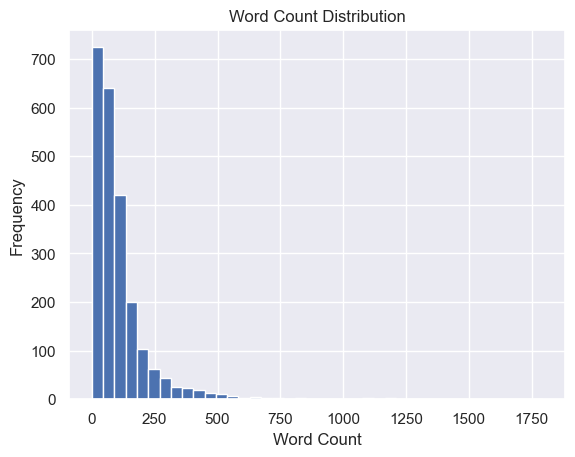

In [9]:
#Analyse Datensatz

df['summary_word_count'] = df['cleaned_selftext'].astype('str').str.count(' ')

print(df.summary_word_count.describe())

# word count distribution
N = 100
print('{} documents in total'.format(df.shape[0]))
print('{} documents have fewer than {N} words'.format(df[df.summary_word_count<=N].shape[0], N = N))
print('{}% documents have fewer than {N} words'.format(round(df[df.summary_word_count<=N].shape[0]/df.shape[0]*100, 1), N = N))

ax = df.summary_word_count.plot.hist(bins=40)
ax.set_title("Word Count Distribution")
ax.set_xlabel('Word Count')

In [10]:
article_summaries = df['cleaned_selftext'].values
article_summaries = [[word for word in nltk.word_tokenize(article)] for article in article_summaries]

# create a dictionary of all the words in the dataset
dictionary = corpora.Dictionary(article_summaries)

# create a corpus
corpus = [dictionary.doc2bow(article) for article in article_summaries]

# create an LDA model
lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20)

2023-07-05 15:05:56,639 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-07-05 15:05:56,715 : INFO : built Dictionary<10761 unique tokens: ['admit', 'affect', 'amount', 'average', 'cash']...> from 2319 documents (total 185043 corpus positions)
2023-07-05 15:05:56,716 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<10761 unique tokens: ['admit', 'affect', 'amount', 'average', 'cash']...> from 2319 documents (total 185043 corpus positions)", 'datetime': '2023-07-05T15:05:56.715967', 'gensim': '4.3.1', 'python': '3.11.3 (v3.11.3:f3909b8bc8, Apr  4 2023, 20:12:10) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-13.2.1-arm64-arm-64bit', 'event': 'created'}
2023-07-05 15:05:56,770 : INFO : using symmetric alpha at 0.1
2023-07-05 15:05:56,770 : INFO : using symmetric eta at 0.1
2023-07-05 15:05:56,771 : INFO : using serial LDA version on this node
2023-07-05 15:05:56,776 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the 

In [11]:
coherence_model_lda = CoherenceModel(model=lda, texts=article_summaries, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

2023-07-05 15:06:06,178 : INFO : using ParallelWordOccurrenceAccumulator<processes=7, batch_size=64> to estimate probabilities from sliding windows
2023-07-05 15:06:09,772 : INFO : 2 batches submitted to accumulate stats from 128 documents (-739 virtual)
2023-07-05 15:06:10,053 : INFO : 7 accumulators retrieved from output queue
2023-07-05 15:06:10,070 : INFO : accumulated word occurrence stats for 50932 virtual documents


Coherence Score:  0.36796931545614325


In [12]:
lda_vis = pyLDAvis.gensim.prepare(
    lda,
    corpus, 
    dictionary=lda.id2word,
    mds='mmds',
    sort_topics=False
)

pyLDAvis.display(lda_vis)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


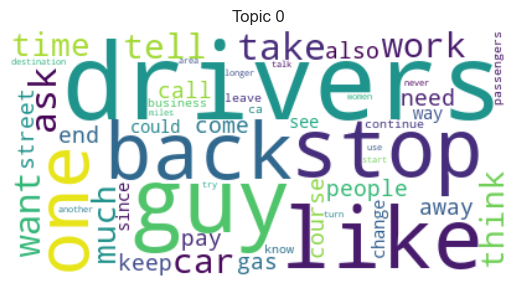

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


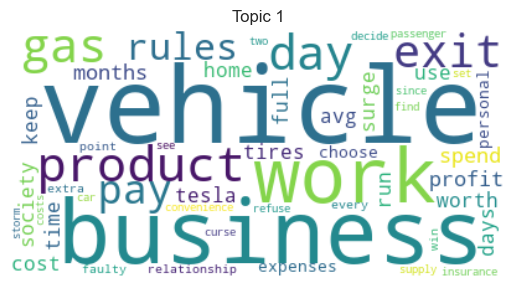

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


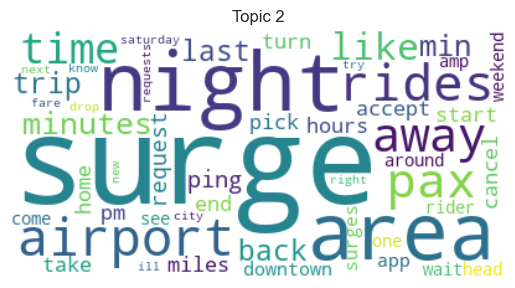

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


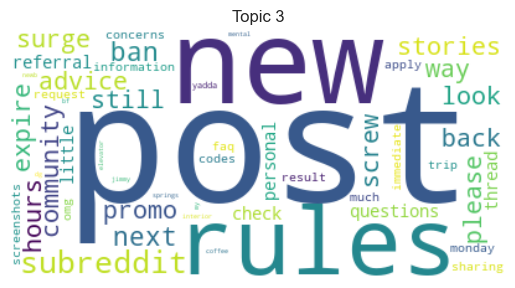

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


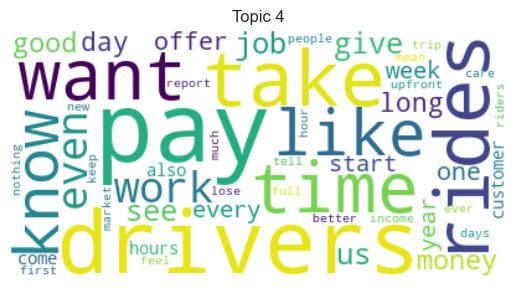

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


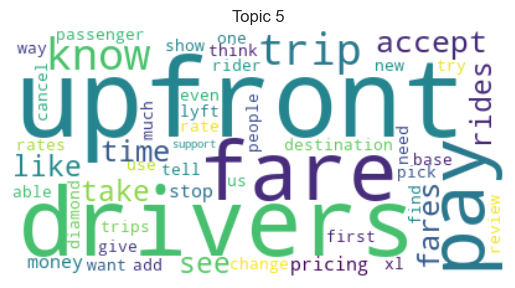

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


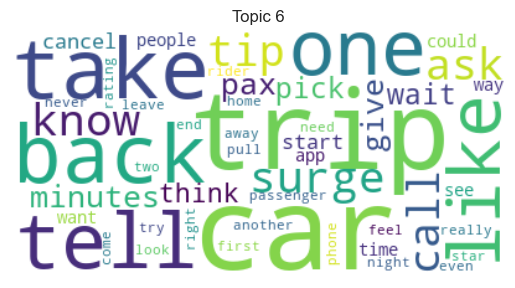

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


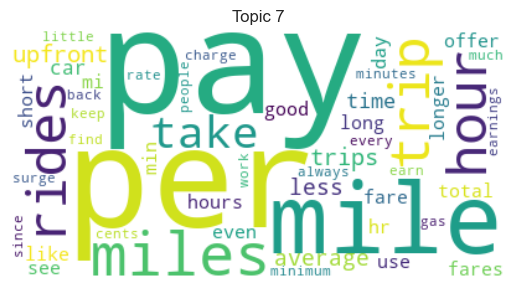

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


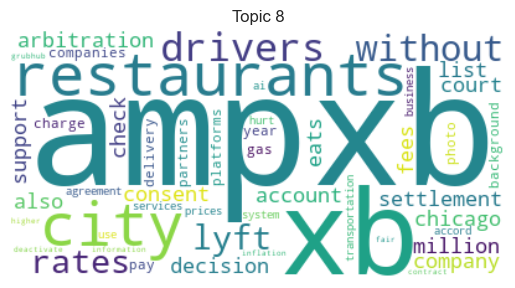

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


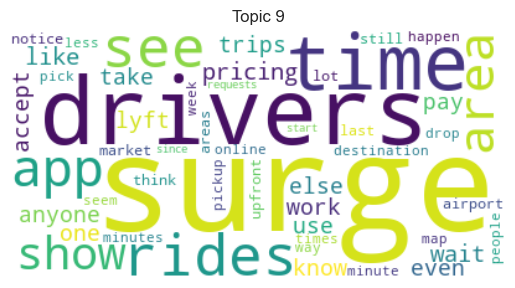

In [13]:
def create_wordcloud(model: models.LdaModel, topic: int):
    '''
    This class will generate a word cloud given an LDA Model and the topic.
    
    Args:
        mdl: LDA Model
        topic: Integer representing the topic
    '''
    
    text = {word: value for word, value in model.show_topic(topic, topn=50)}
    wc = WordCloud(
        background_color="white",
        max_words=1000
    )
    wc.generate_from_frequencies(text)
    plt.clf()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()
    
for i in range (0,10):
    create_wordcloud(lda, topic=i)

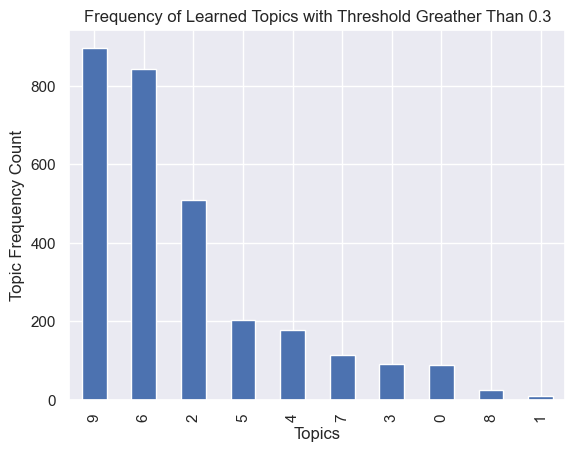

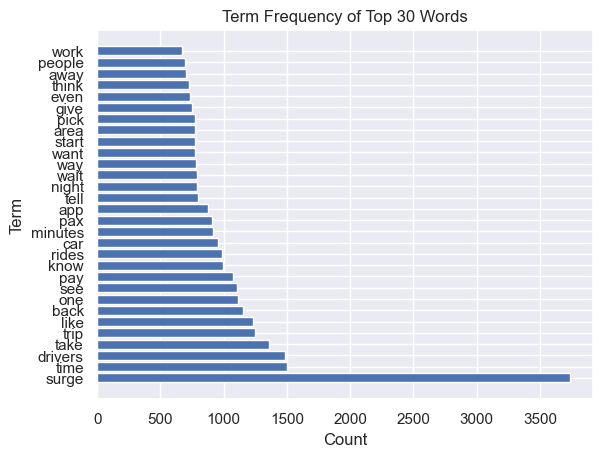

In [14]:
def top_relevant_topics_per_article(mdl: models.LdaModel, corpus: list, articles: list, th: int) -> pd.DataFrame:
    df = []
    
    for i, article in enumerate(articles):
        topics = mdl.get_document_topics(corpus[i])
        topics = sorted(topics, key = lambda x : x[1], reverse = True)[:5]
        for topic in topics:
            proba = topic[1]
            if proba > th:
                data = {
                    "article" : article,
                    "topic" : topic[0],
                    "proba" : proba
                }
                df.append(pd.DataFrame([data]))
    return pd.concat(df)

th = 0.3
articles = [' '.join(article) for article in article_summaries]
rel_df = top_relevant_topics_per_article(lda, corpus, articles, th)

plt.clf()
rel_df['topic'].value_counts().plot(kind = 'bar')
plt.xlabel("Topics")
plt.ylabel("Topic Frequency Count")
plt.title("Frequency of Learned Topics with Threshold Greather Than {th}".format(th=th))
plt.show()

list_sorted_token = sorted(lda.id2word.cfs.items(), key=lambda item: item[1], reverse=True)

term_freq_df = pd.DataFrame(
    data={
        'term' : [lda.id2word[key] for (key, value) in list_sorted_token],
        'term_freq': [value for (key, value) in list_sorted_token]
    }
)

N = 30
plt.clf()
plt.barh(
    term_freq_df.head(N)['term'],
    term_freq_df.head(N)['term_freq']
)
plt.xlabel("Count")
plt.ylabel("Term")
plt.title("Term Frequency of Top {N} Words".format(N = N))
plt.show()


In [15]:
# Extrahiere die Topics mit den Keywords
topics = lda.show_topics(num_topics=10, num_words=5, formatted=False)

# Extrahiere die Anzahl der Dokumente pro Topic
topic_document_counts = [0] * 10
for doc_topics in lda.get_document_topics(corpus):
    for topic_id, _ in doc_topics:
        topic_document_counts[topic_id] += 1

# Extrahiere die Keywords pro Topic
topic_keywords = [', '.join([word for word, _ in lda.show_topic(topic_id, topn=5)]) for topic_id in range(10)]

# Erstelle den DataFrame
df_topics = pd.DataFrame()
df_topics['Topic'] = range(10)
df_topics['Anzahl Dokumente'] = topic_document_counts
df_topics['Keywords'] = topic_keywords

# Gib den DataFrame aus
print(df_topics)


   Topic  Anzahl Dokumente                               Keywords
0      0               740         drivers, guy, like, stop, back
1      1               300  vehicle, business, work, product, day
2      2              1145     surge, night, area, airport, rides
3      3               410       post, new, rules, subreddit, ban
4      4               900        pay, drivers, take, rides, want
5      5               804      upfront, drivers, fare, pay, trip
6      6              1439            car, trip, take, back, tell
7      7               670            pay, per, mile, miles, trip
8      8               429  ampxb, xb, restaurants, city, drivers
9      9              1498       surge, drivers, time, rides, see


In [16]:

# Schleife über alle Topic-Nummern
for topic_num in range(10):
    topic_df = rel_df[rel_df["topic"] == topic_num]  # Filtern des DataFrames für die aktuelle Topic-Nummer
    
    # Dateiname für die CSV-Datei
    filename = f"topic_{topic_num}.csv"
    filepath = os.path.join("Topics", filename)
    
    # Speichern des gefilterten DataFrames in einer CSV-Datei
    topic_df.to_csv(filepath, index=False)

In [17]:
print(article_summaries[1])

['following', 'email', 'today', 'want', 'everything', 'keep', 'cars', 'full', 'slow', 'winter', 'effective', 'thursday', 'january', 'lower', 'avg', 'uberx', 'fares', 'drastically', 'lower', 'commissions', 'fares', 'away', 'rounding', 'feature', 'riders', 'help', 'fund', 'cut', 'point', 'lower', 'prices', 'consumers', 'spur', 'trips', 'soften', 'impact', 'partners', 'drastically', 'lower', 'cut', 'fares', 'details', 'commission', 'dropping', 'lower', 'commissions', 'take', 'uberx', 'fares', 'promotion', 'initially', 'plan', 'bring', 'back', 'promotional', 'commissions', 'normal', 'think', 'appropriate', 'thing', 'winter', 'slowdown', 'help', 'push', 'volume', 'ubersf', 'sacrifice', 'almost', 'revenue', 'help', 'partners', 'riders', 'winter', 'commission', 'rate', 'apply', 'entire', 'sf', 'bay', 'area', 'include', 'east', 'bay', 'south', 'bay', 'north', 'bay', 'rounding', 'round', 'fares', 'increase', 'fares', 'average', 'per', 'increase', 'drivers', 'offset', 'portion', 'price', 'cut', 